Week 2 Notebook: Data Formats and Exploration
===============================================================

Particle physics uses a data format (and analysis ecosystem) based on the `ROOT` library: https://root.cern.ch/.
`ROOT` is a framework for data processing, born at CERN, at the heart of the research on high-energy physics. 
A `ROOT` file is a compressed binary file in which we can save objects of any type.
There are python bindings built into `ROOT`, so called `PyROOT`, but for now we won't discuss this.

Recently, a different library called `uproot` has been developed allowing python users to do `ROOT` I/O directly: https://uproot.readthedocs.io/en/latest/.
`uproot` is a reader and a writer of the `ROOT` file format using only `Python` and `Numpy`. 
Unlike the standard C++ `ROOT` implementation, uproot is only an I/O library, primarily intended to stream data into machine learning libraries in `Python`. 
Unlike `PyROOT` and `root_numpy`, uproot does not depend on C++ `ROOT`. 
Instead, it uses `Numpy` to cast blocks of data from the `ROOT` file as `Numpy` arrays.
It can also make jagged or awkward arrays based on this library: https://github.com/scikit-hep/awkward-1.0 {cite}`Pivarski:2020qcb`.


For a tutorial on `uproot`, see: https://hsf-training.github.io/hsf-training-uproot-webpage/ or here: https://github.com/jpivarski-talks/2020-07-13-pyhep2020-tutorial.

In [1]:
import uproot

## Remote files
One nice feature of `ROOT` and `uproot` is the ability to read a file remotely. 
This is done using the `XRootD` library: https://xrootd.slac.stanford.edu/.
`XRootD` is a generic suite for fast, low latency and scalable data access, which can serve natively any kind of data, organized as a hierarchical filesystem-like namespace, based on the concept of directory. 

## XRootD filenames
We specify that this is a remote file accessed via `XRootD` using the `root://` protocol in front of the filename. 
The redirector `eospublic.cern.ch` specifies that we're accessing data from the CERN open data repository. 
And finally the rest of the file name `/eos/opendata/cms/datascience/HiggsToBBNtupleProducerTool/HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC/train/ntuple_merged_10.root` specifies the exact file.

In [2]:
f = uproot.open('root://eospublic.cern.ch//eos/opendata/cms/datascience/HiggsToBBNtupleProducerTool/HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC/train/ntuple_merged_10.root')

## Trees
One common object is a tree. 
Trees in `ROOT` are basically just tables of information. 
Trees are composed of branches, which are the columns of the table. 
The rows usually represent events (individual bunch crossings).
However, in this case, each row represents a jet (a localized collection of particles within a single event).

First we assign the tree to a variable (named `tree` here).
We can see how many rows (jets) are contained in the tree, by checking its length.

In [3]:
tree = f['deepntuplizer/tree']
print(len(tree))

200000


Let's list the contents (branches) of the tree.

In [4]:
tree.show()

Delta_gen_pt               (no streamer)              asdtype('>f4')
event_no                   (no streamer)              asdtype('>u4')
gen_pt                     (no streamer)              asdtype('>f4')
isB                        (no streamer)              asdtype('>i4')
isBB                       (no streamer)              asdtype('>i4')
isC                        (no streamer)              asdtype('>i4')
isG                        (no streamer)              asdtype('>i4')
isLeptonicB                (no streamer)              asdtype('>i4')
isLeptonicB_C              (no streamer)              asdtype('>i4')
isS                        (no streamer)              asdtype('>i4')
isUD                       (no streamer)              asdtype('>i4')
isUndefined                (no streamer)              asdtype('>i4')
jet_corr_pt                (no streamer)              asdtype('>f4')
jet_eta                    (no streamer)              asdtype('>f4')
jet_looseId                (no str

## A note on "jaggedness"

Some branches are listed has having an interpretation of `asdtype('>f4')` while some others are listed as `asjagged(asdtype('>f4'), 10)`.
The former means there is only one number per jet.
The latter means there may a variable number per jet. 

First, let's get just look at non-jagged arrays, starting with the ground truth labels.

In [5]:
# Returns a dictionary
labels = tree.arrays(branches=['label_QCD_b', 
                               'label_QCD_bb', 
                               'label_QCD_c', 
                               'label_QCD_cc', 
                               'label_QCD_others', 
                               'label_H_bb', 
                               'sample_isQCD'], 
                     entrystop=20000,
                     namedecode='utf-8')
labels

{'label_QCD_b': array([0, 0, 0, ..., 0, 0, 0], dtype=int32),
 'label_QCD_bb': array([0, 0, 0, ..., 0, 0, 0], dtype=int32),
 'label_QCD_c': array([0, 0, 0, ..., 0, 0, 0], dtype=int32),
 'label_QCD_cc': array([0, 0, 0, ..., 0, 1, 1], dtype=int32),
 'label_QCD_others': array([1, 1, 1, ..., 1, 0, 0], dtype=int32),
 'label_H_bb': array([0, 0, 0, ..., 0, 0, 0], dtype=int32),
 'sample_isQCD': array([1, 1, 1, ..., 1, 1, 1], dtype=int32)}

In [6]:
# label QCD: require the sample to be QCD and any of the QCD flavors
label_QCD = labels['sample_isQCD'] * (labels['label_QCD_b'] + \
                                      labels['label_QCD_bb'] + \
                                      labels['label_QCD_c'] + \
                                      labels['label_QCD_cc'] + \
                                      labels['label_QCD_others'])

# label Hbb
label_Hbb = labels['label_H_bb']

In [7]:
# number of overlap jets
sum(label_QCD*label_Hbb) 

0

In [8]:
# fraction of jets with some truth label defined 
sum(label_QCD+label_Hbb)/len(label_QCD+label_Hbb)

0.93785

In [9]:
# jet features, namely transverse momemntum (pt) and soft-drop mass  (sdmass or msd)
jet_features = tree.arrays(branches=['fj_pt', 
                                     'fj_sdmass'],
                          entrystop=20000,
                          namedecode='utf-8')

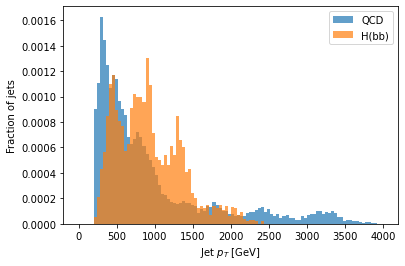

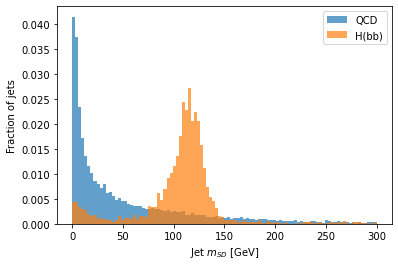

In [10]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure()

plt.hist(jet_features['fj_pt'],weights=label_QCD,bins=np.linspace(0,4000,101),density=True,alpha=0.7,label='QCD')
plt.hist(jet_features['fj_pt'],weights=label_Hbb,bins=np.linspace(0,4000,101),density=True,alpha=0.7,label='H(bb)')
plt.xlabel(r'Jet $p_{T}$ [GeV]')
plt.ylabel('Fraction of jets')
plt.legend()

plt.figure()

plt.hist(jet_features['fj_sdmass'],weights=label_QCD,bins=np.linspace(0,300,101),density=True,alpha=0.7,label='QCD')
plt.hist(jet_features['fj_sdmass'],weights=label_Hbb,bins=np.linspace(0,300,101),density=True,alpha=0.7,label='H(bb)')
plt.xlabel(r'Jet $m_{SD}$ [GeV]')
plt.ylabel('Fraction of jets')
plt.legend()

plt.show()

## Jagged arrys

Now let's look at a jagged array, like those related to track features, where there can be a variable number of tracks per jet.

In [11]:
track_features = tree.arrays(branches=['track_pt',
                                       'label_H_bb'],
                             entrystop=20000,
                             namedecode='utf-8')
track_features

{'track_pt': <JaggedArray [[1.0537109 0.95654297 1.4570312 ... 18.171875 1.6171875 1.234375] [2.7832031 3.5253906 49.09375 ... 3.8613281 1.4599609 1.4306641] [1.5302734 6.8164062 2.9257812 ... 25.6875 36.3125 1.1513672] ... [1.0810547 2.5234375 10.265625 ... 1.25 24.453125 8.4921875] [4.8125 2.6796875 3.9824219 ... 4.3359375 23.375 6.3242188] [2.4101562 1.4345703 2.4628906 ... 57.59375 1.0419922 2.9726562]] at 0x7fd57afece10>,
 'label_H_bb': array([0, 0, 0, ..., 0, 0, 0], dtype=int32)}

Note the difference between a "flat" array, where these a fixed number per jet (like 1 per jet in the case of jet properties) and a jagged array, where there are a variable number. 

We can demonstrate this by looking at the first jet in the dataset. As we'll see there are 21 tracks, each with their own pt.

In [12]:
jet_features['fj_pt'][0]

251.27692

In [13]:
track_features['track_pt'][0]

array([ 1.0537109 ,  0.95654297,  1.4570312 ,  1.0917969 ,  3.1660156 ,
        3.3886719 ,  6.8554688 ,  3.4257812 ,  1.8662109 ,  2.890625  ,
        7.5898438 ,  1.4970703 ,  5.0117188 , 62.875     ,  7.0195312 ,
       11.125     ,  4.5429688 , 14.125     , 18.171875  ,  1.6171875 ,
        1.234375  ], dtype=float32)

Note, behind the scenes jagged arrays are just like normal numpy arrays, except there's additional structure, ecoded in the starts/stops/counts vectors.

In [14]:
track_features['track_pt'].starts

array([     0,     21,     56, ..., 542149, 542174, 542194])

In [15]:
track_features['track_pt'].stops

array([    21,     56,     80, ..., 542174, 542194, 542239])

In [16]:
track_features['track_pt'].counts

array([21, 35, 24, ..., 25, 20, 45])

## Operations with jaggedness

We can plot the full distibution of track pts. But what if we want to find the highest track pt per jet and plot only that?

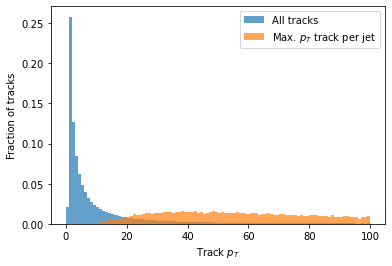

In [17]:
plt.figure()
plt.hist(track_features['track_pt'].flatten(),bins=np.linspace(0,100,101),density=True,alpha=0.7,label='All tracks')
plt.hist(track_features['track_pt'].max(),bins=np.linspace(0,100,101),density=True,alpha=0.7,label=r'Max. $p_{T}$ track per jet')

plt.xlabel(r'Track $p_{T}$')
plt.ylabel('Fraction of tracks')
plt.legend()
plt.show()


## Conversion to regular array

Sometimes we want to turn a jagged array into a regular array to make it easier to accomodate into a machine learning algorithm (like a fully conneted or convolutional neural network). 
The simplest way to do this is to use zero-padding and truncation to "cap" the number of objects at some fixed value, and zero-pad if there are less objects.

To do this, we can first plot how many tracks there are per jet and choose a reasonable number to cap.

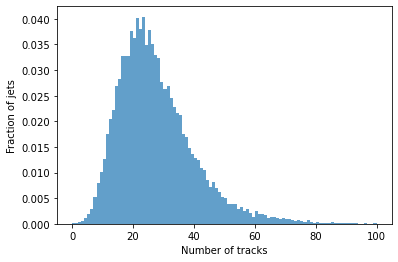

In [18]:
plt.figure()
plt.hist(track_features['track_pt'].counts,bins=np.linspace(0,100,101),density=True,alpha=0.7)

plt.xlabel(r'Number of tracks')
plt.ylabel('Fraction of jets')
plt.show()

In this case, 60 seems to be a reasonable number.

In [19]:
a = track_features['track_pt'].pad(60, clip=True).fillna(0).regular()
print(a.shape)
a

(20000, 60)


array([[ 1.0537109 ,  0.95654297,  1.4570312 , ...,  0.        ,
         0.        ,  0.        ],
       [ 2.7832031 ,  3.5253906 , 49.09375   , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.5302734 ,  6.8164062 ,  2.9257812 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.0810547 ,  2.5234375 , 10.265625  , ...,  0.        ,
         0.        ,  0.        ],
       [ 4.8125    ,  2.6796875 ,  3.9824219 , ...,  0.        ,
         0.        ,  0.        ],
       [ 2.4101562 ,  1.4345703 ,  2.4628906 , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

<hr>

## Exercise
Repeat the exercise with tracks using secondary vertices instead (i.e. find out how many secondary vertices there are per jet, plot their pT, and convert it to a regular zero-padded array).

In [31]:
sv=tree.arrays(branches=['sv_pt',
                         'label_H_bb'], 
                     entrystop=20000,
                     namedecode='utf-8')
sv

{'sv_pt': <JaggedArray [[] [] [] ... [92.24546 76.46198] [5.514913] [23.118647 19.50468 105.82333]] at 0x7fd577f15110>,
 'label_H_bb': array([0, 0, 0, ..., 0, 0, 0], dtype=int32)}

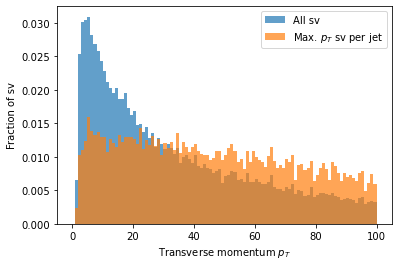

In [38]:
plt.figure()
plt.hist(sv['sv_pt'].flatten(),bins=np.linspace(0,100,101),density=True,alpha=0.7,label='All sv')
plt.hist(sv['sv_pt'].max(),bins=np.linspace(0,100,101),density=True,alpha=0.7,label=r'Max. $p_{T}$ sv per jet')

plt.xlabel(r'Transverse momentum $p_{T}$')
plt.ylabel('Fraction of sv')
plt.legend()
plt.show()

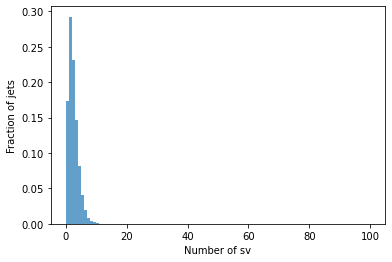

In [39]:
plt.figure()
plt.hist(sv['sv_pt'].counts,bins=np.linspace(0,100,101),density=True,alpha=0.7)

plt.xlabel(r'Number of sv')
plt.ylabel('Fraction of jets')
plt.show()

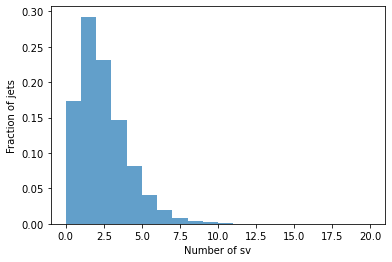

In [40]:
# a zoomed in view
plt.figure()
plt.hist(sv['sv_pt'].counts,bins=np.linspace(0,20,21),density=True,alpha=0.7)

plt.xlabel(r'Number of sv')
plt.ylabel('Fraction of jets')
plt.show()

In [41]:
b = sv['sv_pt'].pad(5, clip=True).fillna(0).regular()
print(b.shape)
b

(20000, 5)


array([[  0.      ,   0.      ,   0.      ,   0.      ,   0.      ],
       [  0.      ,   0.      ,   0.      ,   0.      ,   0.      ],
       [  0.      ,   0.      ,   0.      ,   0.      ,   0.      ],
       ...,
       [ 92.24546 ,  76.46198 ,   0.      ,   0.      ,   0.      ],
       [  5.514913,   0.      ,   0.      ,   0.      ,   0.      ],
       [ 23.118647,  19.50468 , 105.82333 ,   0.      ,   0.      ]],
      dtype=float32)